In [1]:
%matplotlib inline
import zipfile
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
import zipfile
import pickle

from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from xgboost import plot_tree


In [2]:
Dataset = "train"
Dataset1 = "test"
Dataset2 = "sample_submission"

# Will unzip the files so that you can see them..
with zipfile.ZipFile("../input/nyc-taxi-trip-duration/"+Dataset+".zip","r") as z:
    z.extractall("./")

with zipfile.ZipFile("../input/nyc-taxi-trip-duration/"+Dataset1+".zip","r") as z:
    z.extractall("./")

with zipfile.ZipFile("../input/nyc-taxi-trip-duration/"+Dataset2+".zip","r") as z:
    z.extractall("./")

In [3]:
df = pd.read_csv('train.csv')
df.passenger_count = df.passenger_count.astype(np.uint8)
df.vendor_id = df.vendor_id.astype(np.uint8)
df.trip_duration = df.trip_duration.astype(np.uint32)
for c in [c for c in df.columns if c.endswith('tude')]:
    df.loc[:,c] = df[c].astype(np.float32)
print(df.memory_usage().sum()/2**20)
df.pickup_datetime=pd.to_datetime(df.pickup_datetime)
df.dropoff_datetime=pd.to_datetime(df.dropoff_datetime)
df['pu_hour'] = df.pickup_datetime.dt.hour
df['yday'] = df.pickup_datetime.dt.dayofyear
df['wday'] = df.pickup_datetime.dt.dayofweek
df['month'] = df.pickup_datetime.dt.month

75.11797332763672


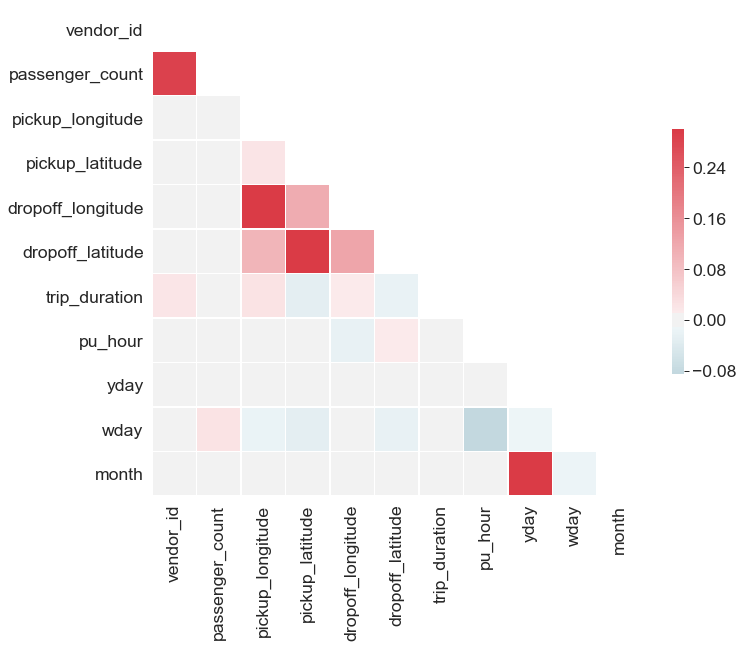

In [4]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

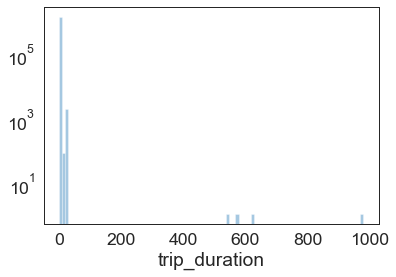

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=100,kde=False,hist_kws={'log':True})

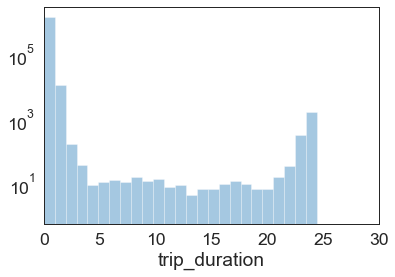

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.set_xlim(0,30)
sns.distplot(df['trip_duration']/3600,ax=ax,bins=1000,kde=False,hist_kws={'log':True})

In [7]:
def haversine(lon1, lat1, lon2, lat2):

    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    miles = km *  0.621371
    return miles

In [8]:
df['distance'] = haversine(df.pickup_longitude, df.pickup_latitude,
                                           df.dropoff_longitude, df.dropoff_latitude)

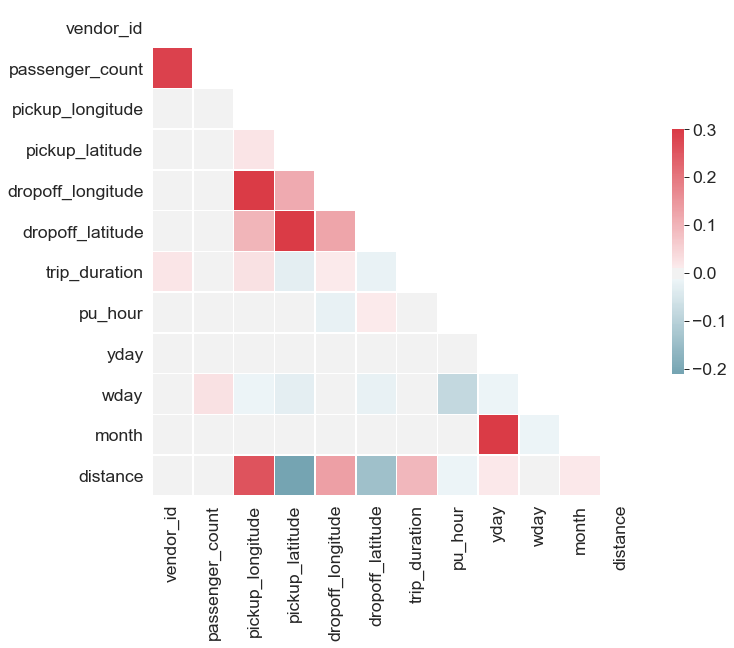

In [9]:
sns.set_style('white')
sns.set_context("paper",font_scale=2)
corr = df.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.3, center=0,
           square=True, linewidths=0.5, cbar_kws={"shrink":0.5})

In [10]:
corr

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,pu_hour,yday,wday,month,distance
vendor_id,1.000000,0.287415,0.007820,0.001742,0.001528,0.004496,0.020304,0.009299,-0.006025,0.001311,-0.006221,0.008109
passenger_count,0.287415,1.000000,0.002169,-0.005125,-0.000343,-0.002762,0.008471,0.009101,-0.001784,0.025191,-0.002143,0.010306
pickup_longitude,0.007820,0.002169,1.000000,0.022568,0.783582,0.100190,0.026542,0.010150,0.004263,-0.016356,0.004474,0.259780
pickup_latitude,0.001742,-0.005125,0.022568,1.000000,0.114884,0.494038,-0.029204,0.010603,-0.002516,-0.028976,-0.001439,-0.210354
dropoff_longitude,0.001528,-0.000343,0.783582,0.114884,1.000000,0.124873,0.014678,-0.022455,0.004612,-0.001130,0.004758,0.134033
dropoff_latitude,0.004496,-0.002762,0.100190,0.494038,0.124873,1.000000,-0.020677,0.013612,-0.001554,-0.021762,-0.000607,-0.142128
trip_duration,0.020304,0.008471,0.026542,-0.029204,0.014678,-0.020677,1.000000,0.003690,0.006625,-0.000708,0.006607,0.094777
pu_hour,0.009299,0.009101,0.010150,0.010603,-0.022455,0.013612,0.003690,1.000000,-0.003340,-0.084255,-0.003438,-0.015813
yday,-0.006025,-0.001784,0.004263,-0.002516,0.004612,-0.001554,0.006625,-0.003340,1.000000,-0.013615,0.985657,0.016443
wday,0.001311,0.025191,-0.016356,-0.028976,-0.001130,-0.021762,-0.000708,-0.084255,-0.013615,1.000000,-0.014544,0.007599


In [11]:
mask = ((df.trip_duration > 60) & (df.distance < 0.05))
df = df[~mask]
mask = (df.trip_duration < 60) 
df = df[~mask]
mask =  df.trip_duration > 79200
df = df[~mask]
mask = df.distance/(df.trip_duration/3600) > 60
df = df[~mask]
df.trip_duration = df.trip_duration.astype(np.uint16)
df = df[df.passenger_count > 0]

In [12]:
m = df.groupby(['wday','vendor_id'])[['trip_duration']].apply(np.median)
m.name = 'trip_duration_median'
df = df.join(m, on=['wday','vendor_id'])

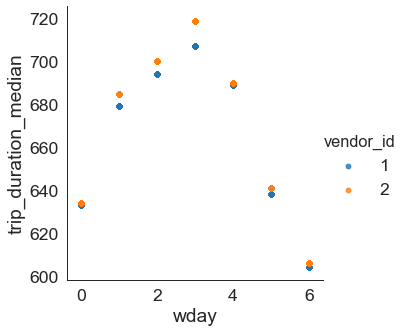

In [13]:
sns.lmplot(y='trip_duration_median', x='wday',data=df, fit_reg=False, hue='vendor_id')

In [14]:
m = df.groupby(['pu_hour','vendor_id'])[['trip_duration']].apply(np.median)
m.name ='trip_duration_median_hour'
df = df.join(m, on=['pu_hour','vendor_id'])

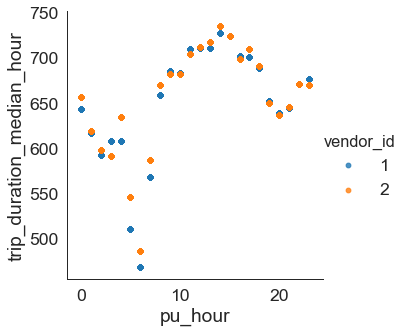

In [15]:
sns.lmplot(y='trip_duration_median_hour', x='pu_hour',data=df, fit_reg=False, hue='vendor_id')

In [16]:
jfk_lon = -73.778889
jfk_lat = 40.639722
lga_lon = -73.872611
lga_lat = 40.77725

In [17]:
df['jfk_pickup_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['lga_pickup_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
df['jfk_dropoff_dist'] = df.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
df['lga_dropoff_dist'] = df.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)

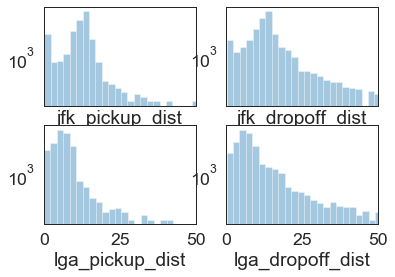

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=2, sharex=True)
ax[0,0].set_xlim(0,50)

sns.distplot(df['jfk_pickup_dist'],ax=ax[0,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['jfk_dropoff_dist'],ax=ax[0,1],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_pickup_dist'],ax=ax[1,0],bins=100,kde=False,hist_kws={'log':True})
sns.distplot(df['lga_dropoff_dist'],ax=ax[1,1],bins=100,kde=False,hist_kws={'log':True})

In [19]:
df['jfk'] = ((df['jfk_pickup_dist'] < 2) | (df['jfk_dropoff_dist'] < 2))
df['lga'] = ((df['lga_pickup_dist'] < 2) | (df['lga_dropoff_dist'] < 2))
df = df.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pu_hour,yday,wday,month,distance,trip_duration_median,trip_duration_median_hour,jfk,lga
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,17,74,0,3,0.930648,634.0,709.0,False,False
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,0,164,6,6,1.121125,604.0,643.0,False,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,11,19,1,1,3.965003,685.0,704.0,False,False
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,19,97,2,4,0.922343,700.0,650.0,False,False
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,13,86,5,3,0.738123,641.0,717.0,False,False


In [20]:
df['workday'] = ((df['pu_hour'] > 8) & (df['pu_hour'] < 18))
df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pu_hour,yday,wday,month,distance,trip_duration_median,trip_duration_median_hour,jfk,lga,workday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,17,74,0,3,0.930648,634.0,709.0,False,False,True
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,164,6,6,1.121125,604.0,643.0,False,False,False
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,11,19,1,1,3.965003,685.0,704.0,False,False,True
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,19,97,2,4,0.922343,700.0,650.0,False,False,False
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,13,86,5,3,0.738123,641.0,717.0,False,False,True


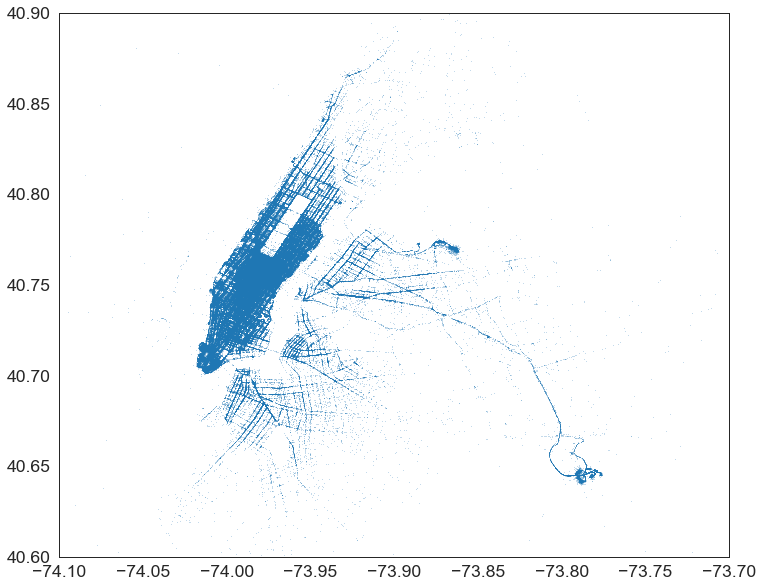

In [21]:
fig, ax = plt.subplots(ncols=1, nrows=1,figsize=(12,10))
plt.ylim(40.6, 40.9)
plt.xlim(-74.1,-73.7)
ax.scatter(df['pickup_longitude'],df['pickup_latitude'], s=0.01, alpha=1)

In [22]:
def rmsle(evaluator,X,real):
    sum = 0.0
    predicted = evaluator.predict(X)
    print("Number predicted less than 0: {}".format(np.where(predicted < 0)[0].shape))

    predicted[predicted < 0] = 0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p-r)**2
    return (sum/len(predicted))**0.5

In [23]:
tdf = pd.read_csv('test.csv')
tdf.pickup_datetime=pd.to_datetime(tdf.pickup_datetime)
#tdf.dropoff_datetime=pd.to_datetime(tdf.dropoff_datetime)
tdf['pu_hour'] = tdf.pickup_datetime.dt.hour
tdf['yday'] = tdf.pickup_datetime.dt.dayofyear
tdf['wday'] = tdf.pickup_datetime.dt.dayofweek
tdf['month'] = tdf.pickup_datetime.dt.month
tdf['distance'] = haversine(tdf.pickup_longitude, tdf.pickup_latitude,
                                           tdf.dropoff_longitude, tdf.dropoff_latitude)


tdf['jfk_pickup_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['lga_pickup_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['pickup_longitude'],row['pickup_latitude']), axis=1)
tdf['jfk_dropoff_dist'] = tdf.apply(lambda row: haversine(jfk_lon, jfk_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['lga_dropoff_dist'] = tdf.apply(lambda row: haversine(lga_lon, lga_lat, row['dropoff_longitude'],row['dropoff_latitude']), axis=1)
tdf['jfk'] = ((tdf['jfk_pickup_dist'] < 2) | (tdf['jfk_dropoff_dist'] < 2))
tdf['lga'] = ((tdf['lga_pickup_dist'] < 2) | (tdf['lga_dropoff_dist'] < 2))
tdf = tdf.drop(['jfk_pickup_dist','lga_pickup_dist','jfk_dropoff_dist','lga_dropoff_dist'],axis=1)
tdf['workday'] = ((tdf['pu_hour'] > 8) & (tdf['pu_hour'] < 18))

In [24]:
tdf.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pu_hour,yday,wday,month,distance,jfk,lga,workday
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,23,182,3,6,1.705478,False,False,False
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,23,182,3,6,1.713435,False,False,False
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,23,182,3,6,0.811098,False,False,False
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,23,182,3,6,3.272003,False,False,False
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,23,182,3,6,0.596664,False,False,False


In [25]:
df.to_csv('train_data.csv',index=False)
tdf.to_csv('test_data.csv',index=False)

In [26]:
df = pd.read_csv('train_data.csv')
tdf = pd.read_csv('test_data.csv')

In [27]:
features = df[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','jfk','lga']]
target = df['trip_duration']

In [28]:
tfeatures = tdf[['vendor_id','passenger_count','pickup_latitude','pickup_longitude','dropoff_latitude','dropoff_longitude','pu_hour','wday','month','workday','jfk','lga']]

In [29]:
reg = linear_model.LinearRegression()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv, scoring=rmsle))
reg.fit(features, target)

Number predicted less than 0: (2,)
Number predicted less than 0: (3,)
Number predicted less than 0: (0,)
Number predicted less than 0: (4,)
[0.68993128 0.68786929 0.69197507 0.69049663]


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
np.mean([0.43999617,  0.44022755 , 0.43897449,0.44073678])

0.4399837475

In [31]:
tfeatures.shape

(625134, 12)

In [32]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)
pred[pred < 0]=0

(35,)


In [33]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]

In [34]:
out['trip_duration'].isnull().values.any()

False

In [35]:
out.to_csv('pred_linear.csv',index=False)
#RMSLE=0.535

In [36]:
neigh = KNeighborsRegressor(n_neighbors=10)
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(neigh, features, np.ravel(target), cv=cv,scoring=rmsle))
neigh.fit(features,target)

Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
Number predicted less than 0: (0,)
[0.49370449 0.4897988  0.49427449 0.49141729]


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                    weights='uniform')

In [37]:
np.mean([0.42010954, 0.41940803, 0.41947931, 0.41968818])

0.419671265

In [38]:
pred = neigh.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

(0,)


In [39]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_knn.csv',index=False)
#RMSLE=0.505

In [ ]:
rf = RandomForestRegressor()
cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(rf, features, np.ravel(target), cv=cv,scoring=rmsle))
rf = rf.fit(features,np.ravel(target))

In [ ]:
np.mean([0.35085909, 0.35181223, 0.34976928, 0.35057147])

In [ ]:
pred = rf.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

In [ ]:
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out.to_csv('pred_rf.csv',index=False)
#RMSLE=0.473

In [ ]:
reg = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)

cv = ShuffleSplit(n_splits=4, test_size=0.1, random_state=0)
print(cross_val_score(reg, features, np.ravel(target), cv=cv,scoring=rmsle))
reg.fit(features,target)

In [ ]:
pred = reg.predict(tfeatures)
print(np.where(pred < 0)[0].shape)

In [ ]:
pred[pred < 0] = 0
tdf['trip_duration']=pred.astype(int)
out = tdf[['id','trip_duration']]
out['trip_duration'].isnull().values.any()
out.to_csv('pred_xgboost.csv',index=False)
#RMSLE=0.463

In [ ]:
plot_tree(reg)

In [ ]:
pickle.dump(reg, open('xgb_model.sav','wb'),protocol=2)

In [ ]:
# DISCLAIMER: THIS CODE IS A RESULT OF FOLLOWING THIS TUTORIAL: https://www.youtube.com/watch?v=suRd3UzdBeo